In [1]:
import torch
print(torch.__version__)

2.0.0+cu118


# Import the required library

In [2]:
from torch.utils.data import Dataset, DataLoader ,random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
import torch.nn as nn 
import time

# Define the hyper parameters

In [19]:
batch_size=32
val_ratio=0.1
epochs=20
learning_rate=1E-3

#Let's download the data

In [4]:
train_data=CIFAR10(root='./content',train=True,download=True,transform=ToTensor())
test_data=CIFAR10(root='./content',train=False,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:04<00:00, 42362817.03it/s]


Extracting ./content/cifar-10-python.tar.gz to ./content
Files already downloaded and verified


#Check the length of the data

In [6]:
len(train_data),len(test_data)

(50000, 10000)

# Create a size for validation and training of the data

In [9]:
val_size=int(val_ratio*len(train_data))
train_size=int((1-val_ratio)*len(train_data))

#Split the data in training and testing data

In [10]:
training_data,val_data=random_split(train_data,[train_size,val_size])

#Create the data batches

In [12]:
train_loader=DataLoader(training_data,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

#Define the model

In [16]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()

    self.model=nn.Sequential(nn.Conv2d(3,32,3),
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             nn.Dropout(0.25),
                             
                             nn.Conv2d(32,64,3),
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             nn.Dropout(0.25),
                             
                             nn.Flatten(),
                             nn.Linear(64*6*6,512),
                             nn.ReLU(),
                             nn.Dropout(0.5),

                             #Last layer
                             nn.Linear(512,10))
  def forward(self,inputs):
    pred=self.model(inputs)
    return pred

#Create a device

In [17]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model=CNN()
model.to(device)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

# Define the optimization functions

In [20]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

# Create the training model

In [26]:
def Model_training(train_values,model,loss_func,optimizer):
  Loss_history=[]
  size=len(train_values)
  for batch, (images,labels) in enumerate(train_values):
    images, labels=images.to(device),labels.to(device)

    predicted=model(images)

    loss=loss_func(predicted,labels)
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch+1)%100==0:
      loss,current=loss.item(), (batch+1)*len(images)
      Loss_history.append(loss)
      print(f'Loss : {loss:>7f} [{current: >5d}/{size:>5d}]')
  return Loss_history


#Create the evaluation function

In [36]:
def Model_evaluate(eval_dat,model):
  test_size=len(eval_dat.dataset)
  correct_pred=0
  with torch.no_grad():
    for image,label in eval_dat:
      test_pred=model(image)
      closest_pred_index=test_pred.argmax(1)
      correct_pred +=(closest_pred_index==label).sum().item()
  return  100*correct_pred/test_size 





In [32]:
def train_mdel(model,loss_f,optimizer):

  strt_time=time.time()
  Full_loss=[]

  for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}\n ------------------------------------------------------------')

    epoch_start_time=time.time()
    model.train()
    train_loss=Model_training(train_loader,model,loss_f,optimizer)
    Full_loss.append(train_loss)
    #Let's set the droput to the model evaluation

    model.eval()

    val_accuracy=Model_evaluate(val_loader, model)

    epoch_elapsed_time=time.time()-epoch_start_time

    print(f'Epoch {epoch + 1} completed in {epoch_elapsed_time: .3f}s,'f'val_accuracy: {val_accuracy: .3f}%\n')
    train_elapsed_time=time.time()-strt_time


    print(f' Training completed in {train_elapsed_time:.3f}s')

    model.eval()
    train_accuracy=Model_evaluate(train_loader,model)

    print(f'The training accuracy is : {train_accuracy:.3f}%')

    test_accuracy=Model_evaluate(test_loader,model)

    print(f'The test accurancy is: {test_accuracy: .3f}% ')
    
    return Full_loss




# Let's now train the model

In [37]:
train_mdel(model,loss_func,optimizer)

Epoch: 1
 ------------------------------------------------------------
Loss : 1.034771 [ 3200/ 1407]
Loss : 1.032641 [ 6400/ 1407]
Loss : 1.135057 [ 9600/ 1407]
Loss : 1.015456 [12800/ 1407]
Loss : 1.227483 [16000/ 1407]
Loss : 0.852989 [19200/ 1407]
Loss : 0.932443 [22400/ 1407]
Loss : 1.464880 [25600/ 1407]
Loss : 0.902383 [28800/ 1407]
Loss : 1.074207 [32000/ 1407]
Loss : 1.157087 [35200/ 1407]
Loss : 1.316920 [38400/ 1407]
Loss : 0.997049 [41600/ 1407]
Loss : 1.358635 [44800/ 1407]
Epoch 1 completed in  89.900s,val_accuracy:  62.940%

 Training completed in 89.901s
The training accuracy is : 66.660%
The test accurancy is:  63.540% 


[[1.03477144241333,
  1.0326411724090576,
  1.135056734085083,
  1.0154564380645752,
  1.2274826765060425,
  0.852988600730896,
  0.9324426054954529,
  1.4648804664611816,
  0.9023827314376831,
  1.0742071866989136,
  1.1570874452590942,
  1.3169195652008057,
  0.9970488548278809,
  1.3586350679397583]]

In [38]:
import matplotlib.pyplot as plt
dd=[1.03477144241333,
  1.0326411724090576,
  1.135056734085083,
  1.0154564380645752,
  1.2274826765060425,
  0.852988600730896,
  0.9324426054954529,
  1.4648804664611816,
  0.9023827314376831,
  1.0742071866989136,
  1.1570874452590942,
  1.3169195652008057,
  0.9970488548278809,
  1.3586350679397583]

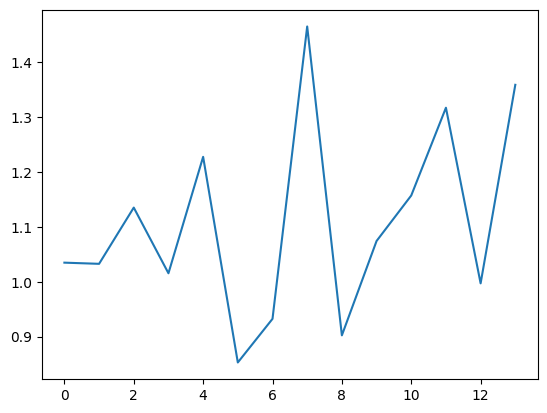

In [39]:
plt.plot(dd)